## The goal of Decision Tree is to create a model that predicts the value of a target variable by learning simple decision rules inferred from the data features. 

In [1]:
from warnings import filterwarnings
filterwarnings("ignore")

import sys
sys.path.append('../common')

from print_more_stuff import print_more_stuff
from preprocessing import mean_and_std
from regression_models import dosomething

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

In [2]:
outliers_df = pd.read_csv('geocoded.csv')
outliers_df.drop(columns=["Unnamed: 0"],inplace=True)

#### Create new feature prev_sold_year from prev_sold_date

#### Find the zip code of that has the most houses.

In [3]:
groupby_zipcode = outliers_df.groupby(["zip_code"])["zip_code"].count().sort_values(ascending=False)
groupby_zipcode_df = pd.DataFrame(groupby_zipcode).rename(columns={"zip_code":"count"}).reset_index()
first_zipcode = groupby_zipcode_df.iloc[0]["zip_code"]
first_zipcode

8260.0

#### Find the rows of the zip code that has the most houses.

In [4]:
one_zipcode_df = outliers_df[outliers_df["zip_code"].isin([first_zipcode])]

In [5]:
one_zipcode_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 183 entries, 7066 to 7248
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0.1    183 non-null    int64  
 1   bed             183 non-null    float64
 2   bath            183 non-null    float64
 3   acre_lot        183 non-null    float64
 4   zip_code        183 non-null    float64
 5   house_size      183 non-null    float64
 6   prev_sold_date  183 non-null    object 
 7   price           183 non-null    float64
 8   prev_sold_year  183 non-null    int64  
 9   zip_code_str    183 non-null    int64  
 10  latitude        183 non-null    float64
 11  longitude       183 non-null    float64
dtypes: float64(8), int64(3), object(1)
memory usage: 18.6+ KB


In [6]:
params = {
    "data":one_zipcode_df,
    "features_a":["prev_sold_year"],
    "features_n":["bed","bath","acre_lot","house_size","price"]
    
}
normalize_df = mean_and_std(params)
#normalize_df = one_zipcode_df
normalize_df.tail()

,bed,bath,acre_lot,house_size,price,prev_sold_year
7244,-0.82102,-1.083472,0.216191,-1.368403,-0.931623,2018
7245,-0.82102,-1.083472,0.216191,-1.625842,-0.993673,2022
7246,-1.64204,-1.083472,0.216191,0.080097,-0.993363,2022
7247,0.82102,0.710875,0.216191,0.080097,0.448989,2022
7248,-0.82102,-0.186298,0.216191,0.075209,-0.373173,2017


In [7]:
correlation = normalize_df[["acre_lot","bed","bath","house_size","prev_sold_year","price"]].corr()
correlation["price"]

acre_lot         -0.022765
bed               0.643951
bath              0.801066
house_size        0.669718
prev_sold_year   -0.056514
price             1.000000
Name: price, dtype: float64

Text(0.5, 1.0, 'Correlation Between Variables')

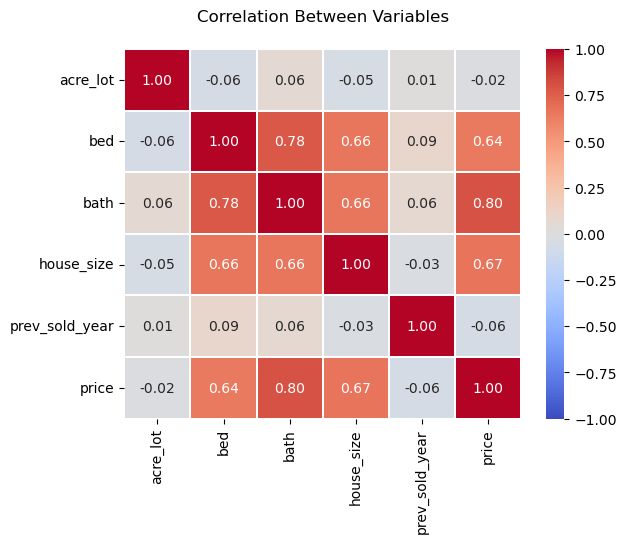

In [8]:
sns.heatmap(correlation, vmin=-1, vmax=1, cmap = 'coolwarm', annot=True, fmt='.2f', linewidths=0.1)
plt.title("Correlation Between Variables", pad=20)

In [9]:
'''
'''
savefeatures = []
for feature, value in correlation["price"].items():
    if abs(value) < 0.81 and abs(value) >= 0.20:
        savefeatures.append(feature)

print(savefeatures)

['bed', 'bath', 'house_size']


#### Create common variables to store frequently used values.

In [10]:
#features = ["acre_lot","bed","bath","house_size","prev_sold_year"]
#features = ["bed","bath","house_size"]
features = savefeatures
num_features_to_select = len(features)-1
random_state_value = 42

#### Datasets for modeling, testing the models, and making predictions.

In [11]:
X = normalize_df[features]
y = normalize_df["price"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state_value)

#### Variable to store the results generated by the models.

In [12]:
results_dict = {"model":[], "explained variance score":[],"mae score":[],"mse score":[],"r2 score":[], "mean fit time":[]}

#### Function to format the results generated by the models.

In [13]:
def results_dict_append(rtnval):
    results_dict["model"].append(rtnval["model"])
    results_dict["explained variance score"].append(rtnval["explained variance score"])
    results_dict["mae score"].append(rtnval["mae score"])
    results_dict["mse score"].append(rtnval["mse score"])
    results_dict["r2 score"].append(rtnval["r2 score"])
    results_dict["mean fit time"].append(rtnval["mean fit time"])

### GridSearchCV exhaustively generates candidates from a grid of parameter values specified.

In [14]:
dtree_gscv = GridSearchCV(DecisionTreeRegressor(random_state=42), {'min_samples_leaf': np.arange(5,15,1)})
dtree_gscv_model = dtree_gscv.fit(X, y)
print(f"Best parameters found: {dtree_gscv.best_params_}")

Best parameters found: {'min_samples_leaf': 10}


#### The best params attribute will be used to fit  model with the training data and make a prediction with the test data.

In [15]:
dtree = dosomething("Decision Tree","Decision Tree Best Params", normalize_df, features, "price", dtree_gscv.best_params_)
results_dict_append(dtree["results"])
dtree_bp_predict = dtree["predictions"]

The selected features are: ['bed', 'bath', 'house_size']
Decision Tree Best Params EVS = 0.501674592
Decision Tree Best Params MSE = 0.556478
Decision Tree Best Params MAE = 0.516455
Decision Tree Best Params R2 = 0.498992
Decision Tree Best Params Fit Time = 0.0027923107147216795


### Recursive feature elimination uses an external estimator that assigns weights to features with the goal of selecting features by recursively considering smaller and smaller sets of features.

In [16]:
dtree_rfe = dosomething("Decision Tree","Recursive Feature Elimination", normalize_df, features, "price")
results_dict_append(dtree_rfe["results"])
dtree_rfe_predict = dtree_rfe["predictions"]

The selected features are: ['bath', 'house_size']
Recursive Feature Elimination EVS = 0.633265979
Recursive Feature Elimination MSE = 0.407339
Recursive Feature Elimination MAE = 0.472611
Recursive Feature Elimination R2 = 0.633265
Recursive Feature Elimination Fit Time = 0.0009940624237060546


###  Sequential Feature Selector (forward selection) adds features to form a feature subset in a greedy fashion. At each stage, this estimator chooses the best feature to add or remove based on the cross-validation score of an estimator.

In [17]:
dtree_sfs = dosomething("Decision Tree","Sequential Feature Selector", normalize_df, features, "price")
results_dict_append(dtree_sfs["results"])
dtree_sfs_predict = dtree_sfs["predictions"]

The selected features are: ['bed', 'bath']
Sequential Feature Selector EVS = 0.542394283
Sequential Feature Selector MSE = 0.508294
Sequential Feature Selector MAE = 0.473491
Sequential Feature Selector R2 = 0.542374
Sequential Feature Selector Fit Time = 0.0


#### Graphing the results works best when the data is provided in a DataFrame.

In [18]:
dtree_bp_predict_df = pd.DataFrame(dtree_bp_predict).reset_index()
dtree_bp_predict_df.rename(columns={0: "prediction"},inplace=True)

dtree_sfs_predict_df = pd.DataFrame(dtree_sfs_predict).reset_index()
dtree_sfs_predict_df.rename(columns={0: "prediction"},inplace=True)

dtree_rfe_predict_df = pd.DataFrame(dtree_rfe_predict).reset_index()
dtree_rfe_predict_df.rename(columns={0: "prediction"},inplace=True)

y_test_df = pd.DataFrame(y_test).reset_index()

#### Scatter Plot graph of the results of Recursive Feature Elimination, Sequential Feature Selection, and Test Data.

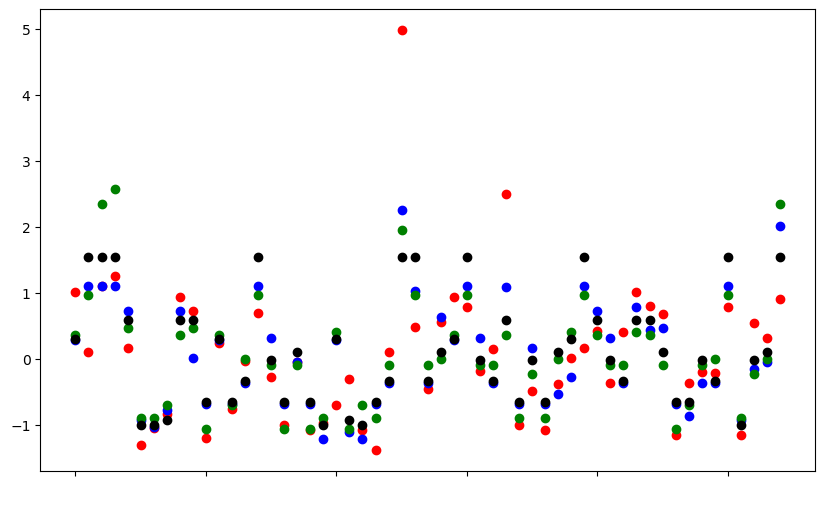

In [19]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.ticklabel_format(style='plain')
ax.xaxis.set_major_formatter(' ')

plt.scatter(y_test_df.index,y_test_df["price"], color="red")
plt.scatter(dtree_rfe_predict_df.index,dtree_rfe_predict_df["prediction"], color="blue")
plt.scatter(dtree_sfs_predict_df.index,dtree_sfs_predict_df["prediction"], color="green")
plt.scatter(dtree_bp_predict_df.index,dtree_bp_predict_df["prediction"], color="black")
plt.show()

In [20]:
results_dict

{'model': ['Decision Tree Best Params',
  'Recursive Feature Elimination',
  'Sequential Feature Selector'],
 'explained variance score': ['0.501674592', '0.633265979', '0.542394283'],
 'mae score': ['0.516455', '0.472611', '0.473491'],
 'mse score': ['0.556478', '0.407339', '0.508294'],
 'r2 score': ['0.498992', '0.633265', '0.542374'],
 'mean fit time': [0.0027923107147216795, 0.0009940624237060546, 0.0]}

In [21]:
model_comparisons = pd.DataFrame(results_dict).set_index('model')
model_comparisons

,explained variance score,mae score,mse score,r2 score,mean fit time
model,,,,,
Decision Tree Best Params,0.501674592,0.516455,0.556478,0.498992,0.002792
Recursive Feature Elimination,0.633265979,0.472611,0.407339,0.633265,0.000994
Sequential Feature Selector,0.542394283,0.473491,0.508294,0.542374,0.000000
